In [5]:
import torch
import pandas as pd
import re
from string import punctuation
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch import nn, optim
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# GPU/CPU device setup
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('Use the GPU:', torch.cuda.get_device_name(0))
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    return device

# Data cleaning function
def clean_text(tweet):
    tweet = re.sub(r"@[A-Za-z0-9_-]+", 'USR', tweet)
    tweet = re.sub(r"http\S+", 'URL', tweet)
    tweet = tweet.replace('\n', ' ').replace('\t', ' ')
    tweet = tweet.translate(str.maketrans('', '', punctuation))
    tweet = tweet.replace('„', '').replace('“', '')
    tweet = re.sub(r'[^\w\s,]', '', tweet)
    tweet = tweet.strip()
    return tweet

# Dataset class
class BERTDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=280):
        self.tok = tokenizer
        self.cleaned_tweets = data['text'].apply(lambda x: clean_text(x))
        self.tweets = list(self.cleaned_tweets.apply(self.tok.encode, max_length=max_length, truncation=True))
        self.labels = list(data['label_value'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        return tweet, label

# Collate function for DataLoader
def bert_collate(batch):
    batch_size = len(batch)
    tweets = [t for t, _ in batch]
    labels = torch.tensor([l for _, l in batch]).long()
    max_len = max(len(t) for t in tweets)
    tweets_pad = torch.zeros((batch_size, max_len)).long()
    masks_pad = torch.zeros((batch_size, max_len)).long()
    for i, t in enumerate(tweets):
        tweets_pad[i, :len(t)] = torch.tensor(t)
        masks_pad[i, :len(t)] = 1
    return tweets_pad, masks_pad, labels

# BERT Classifier
class BERTClassifier(nn.Module):
    def __init__(self, model_name):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.linear = nn.Linear(768, 2)
        self.dropout = nn.Dropout(0.2)

        # Freeze BERT layers
        for n, p in self.bert.named_parameters():
            p.requires_grad = False

    def forward(self, tweets, masks):
        output_bert = self.bert(tweets, attention_mask=masks)[0].mean(axis=1)
        return self.linear(self.dropout(output_bert))

# Training and validation function
def train_model(model, train_loader, dev_loader, device, optimizer, criterion, epochs=5):
    for epoch_i in range(epochs):
        model.train()
        for i, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            tweets, masks, labels = [t.to(device) for t in batch]
            output = model(tweets, masks)
            loss = criterion(output, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch in dev_loader:
                tweets, masks, labels = [t.to(device) for t in batch]
                output = model(tweets, masks)
                max_output = output.argmax(dim=1)
                y_true.extend(labels.tolist())
                y_pred.extend(max_output.tolist())
        print(f"Accuracy after {epoch_i + 1} epoch(s): {accuracy_score(y_true, y_pred)}")

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            tweets, masks, labels = [t.to(device) for t in batch]
            output = model(tweets, masks)
            max_output = output.argmax(dim=1)
            y_true.extend(labels.tolist())
            y_pred.extend(max_output.tolist())

    # Print accuracy and classification report
    print('Test accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\nClassification report: \n', classification_report(y_true, y_pred))

    # Generate confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Function to run the entire process
def run_bert_training(model_name, language):
    device = get_device()

    # Load dataset
    csv_file = "FINAL_resampled_multilingual_all_data.csv"
    resampled_df = pd.read_csv(csv_file)
    df = resampled_df[resampled_df['language'] == language]

    # Split data
    train, test = train_test_split(df, test_size=0.2, stratify=df['label_value'])
    train, dev = train_test_split(train, test_size=0.25, stratify=train['label_value'])

    tokenizer = BertTokenizer.from_pretrained(model_name)
    train_dataset = BERTDataset(train, tokenizer)
    dev_dataset = BERTDataset(dev, tokenizer)
    test_dataset = BERTDataset(test, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=bert_collate, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=100, collate_fn=bert_collate)
    test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=bert_collate)

    model = BERTClassifier(model_name)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    train_model(model, train_loader, dev_loader, device, optimizer, criterion)
    evaluate_model(model, test_loader, device)

There are 1 GPU(s) available.
Use the GPU: Tesla T4


100%|██████████| 56/56 [00:56<00:00,  1.01s/it]


Accuracy after 1 epoch(s): 0.6293519014461704


100%|██████████| 56/56 [00:53<00:00,  1.04it/s]


Accuracy after 2 epoch(s): 0.6304231387252276


100%|██████████| 56/56 [00:55<00:00,  1.00it/s]


Accuracy after 3 epoch(s): 0.6175682913765399


100%|██████████| 56/56 [00:55<00:00,  1.01it/s]


Accuracy after 4 epoch(s): 0.6411355115158007


100%|██████████| 56/56 [00:56<00:00,  1.00s/it]


Accuracy after 5 epoch(s): 0.6384574183181575
Test accuracy: 0.65

Classification report: 
               precision    recall  f1-score   support

           0       0.66      0.61      0.64       933
           1       0.64      0.69      0.66       934

    accuracy                           0.65      1867
   macro avg       0.65      0.65      0.65      1867
weighted avg       0.65      0.65      0.65      1867



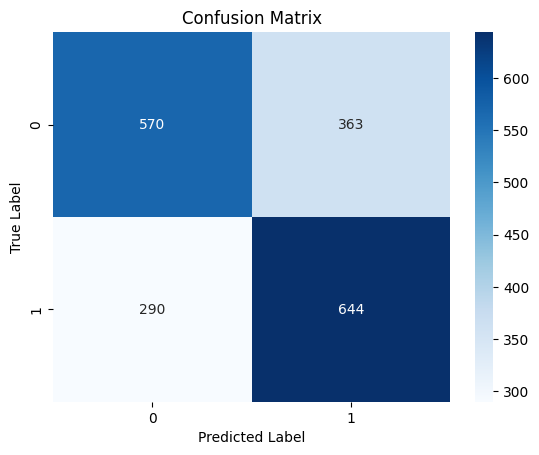

In [6]:
run_bert_training("bert-base-cased", "eng")

There are 1 GPU(s) available.
Use the GPU: Tesla T4


100%|██████████| 56/56 [00:45<00:00,  1.23it/s]


Accuracy after 1 epoch(s): 0.6775575790037494


100%|██████████| 56/56 [00:43<00:00,  1.29it/s]


Accuracy after 2 epoch(s): 0.6850562399571505


100%|██████████| 56/56 [00:43<00:00,  1.28it/s]


Accuracy after 3 epoch(s): 0.6684520621317622


100%|██████████| 56/56 [00:43<00:00,  1.29it/s]


Accuracy after 4 epoch(s): 0.6877343331547938


100%|██████████| 56/56 [00:42<00:00,  1.33it/s]


Accuracy after 5 epoch(s): 0.6582753079807178
Test accuracy: 0.69

Classification report: 
               precision    recall  f1-score   support

           0       0.66      0.78      0.72       934
           1       0.73      0.61      0.66       933

    accuracy                           0.69      1867
   macro avg       0.70      0.69      0.69      1867
weighted avg       0.70      0.69      0.69      1867



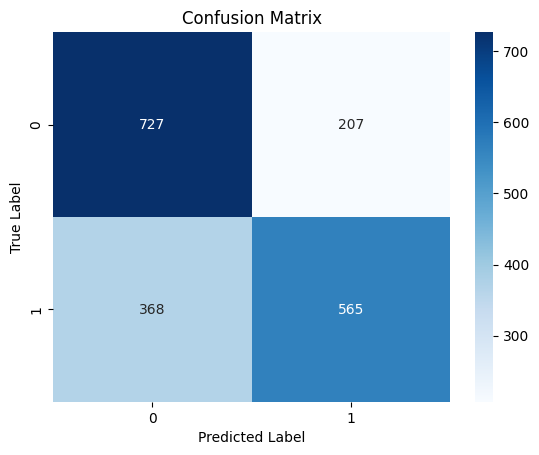

In [9]:
run_bert_training("bert-base-german-cased", "ger")

There are 1 GPU(s) available.
Use the GPU: Tesla T4


100%|██████████| 56/56 [00:59<00:00,  1.07s/it]


Accuracy after 1 epoch(s): 0.6089983931440814


100%|██████████| 56/56 [00:59<00:00,  1.07s/it]


Accuracy after 2 epoch(s): 0.6132833422603107


100%|██████████| 56/56 [00:57<00:00,  1.02s/it]


Accuracy after 3 epoch(s): 0.6116764863417247


100%|██████████| 56/56 [00:58<00:00,  1.04s/it]


Accuracy after 4 epoch(s): 0.6277450455275844


100%|██████████| 56/56 [01:00<00:00,  1.08s/it]


Accuracy after 5 epoch(s): 0.6138189608998393
Test accuracy: 0.62

Classification report: 
               precision    recall  f1-score   support

           0       0.62      0.62      0.62       933
           1       0.62      0.62      0.62       934

    accuracy                           0.62      1867
   macro avg       0.62      0.62      0.62      1867
weighted avg       0.62      0.62      0.62      1867



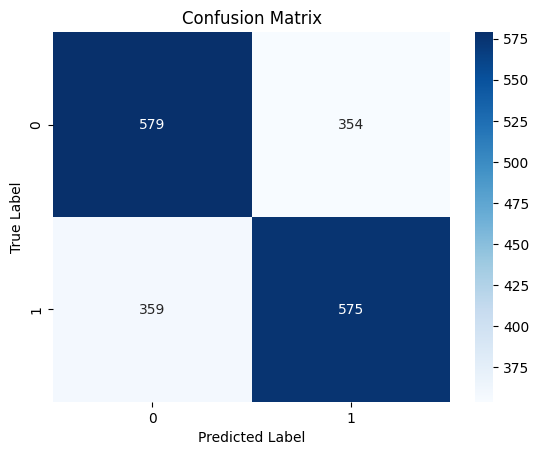

In [14]:
run_bert_training("bert-base-multilingual-cased", "eng")

There are 1 GPU(s) available.
Use the GPU: Tesla T4


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


Accuracy after 1 epoch(s): 0.6336368505623996


100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


Accuracy after 2 epoch(s): 0.6647027316550616


100%|██████████| 56/56 [00:51<00:00,  1.08it/s]


Accuracy after 3 epoch(s): 0.6647027316550616


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


Accuracy after 4 epoch(s): 0.676486341724692


100%|██████████| 56/56 [00:49<00:00,  1.13it/s]


Accuracy after 5 epoch(s): 0.6657739689341189
Test accuracy: 0.67

Classification report: 
               precision    recall  f1-score   support

           0       0.67      0.69      0.68       934
           1       0.68      0.66      0.67       933

    accuracy                           0.67      1867
   macro avg       0.67      0.67      0.67      1867
weighted avg       0.67      0.67      0.67      1867



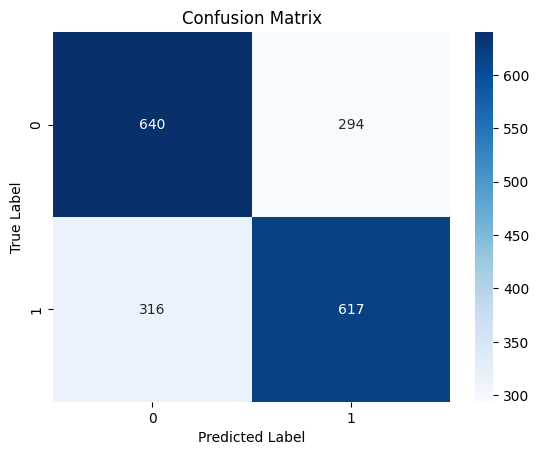

In [15]:
run_bert_training("bert-base-multilingual-cased", "ger")

There are 1 GPU(s) available.
Use the GPU: Tesla T4


100%|██████████| 56/56 [00:56<00:00,  1.02s/it]


Accuracy after 1 epoch(s): 0.626673808248527


100%|██████████| 56/56 [00:53<00:00,  1.04it/s]


Accuracy after 2 epoch(s): 0.6545259775040171


100%|██████████| 56/56 [00:53<00:00,  1.04it/s]


Accuracy after 3 epoch(s): 0.6405998928762721


100%|██████████| 56/56 [00:55<00:00,  1.01it/s]


Accuracy after 4 epoch(s): 0.6432779860739154


100%|██████████| 56/56 [00:52<00:00,  1.06it/s]


Accuracy after 5 epoch(s): 0.64542046063203
Test accuracy: 0.67

Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.58      0.64       934
           1       0.64      0.77      0.70       933

    accuracy                           0.67      1867
   macro avg       0.68      0.67      0.67      1867
weighted avg       0.68      0.67      0.67      1867



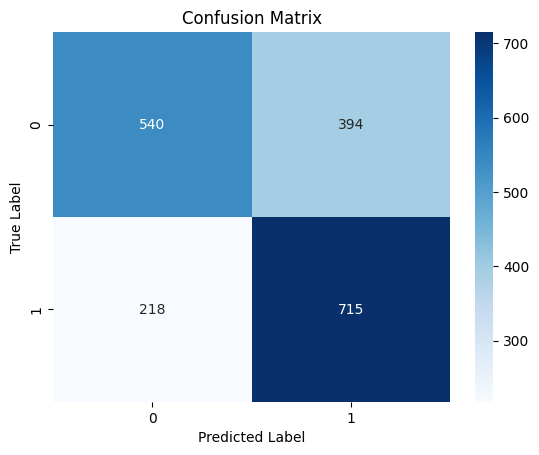

In [17]:
run_bert_training("bert-base-uncased", "eng")

There are 1 GPU(s) available.
Use the GPU: Tesla T4


100%|██████████| 56/56 [01:19<00:00,  1.43s/it]


Accuracy after 1 epoch(s): 0.5570433851098018


100%|██████████| 56/56 [01:22<00:00,  1.48s/it]


Accuracy after 2 epoch(s): 0.5329405463310123


100%|██████████| 56/56 [01:23<00:00,  1.50s/it]


Accuracy after 3 epoch(s): 0.499196572040707


100%|██████████| 56/56 [01:21<00:00,  1.46s/it]


Accuracy after 4 epoch(s): 0.5640064274236744


100%|██████████| 56/56 [01:23<00:00,  1.49s/it]


Accuracy after 5 epoch(s): 0.5286555972147831
Test accuracy: 0.53

Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.10      0.18       934
           1       0.52      0.96      0.67       933

    accuracy                           0.53      1867
   macro avg       0.61      0.53      0.43      1867
weighted avg       0.61      0.53      0.43      1867



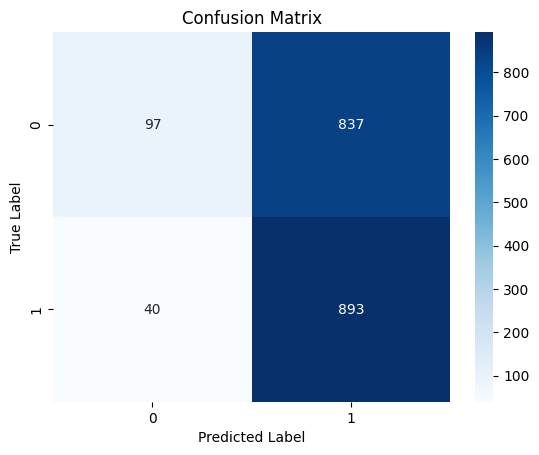

In [18]:
run_bert_training("bert-base-german-cased", "eng")

There are 1 GPU(s) available.
Use the GPU: Tesla T4


100%|██████████| 56/56 [01:16<00:00,  1.37s/it]


Accuracy after 1 epoch(s): 0.5923942153186931


100%|██████████| 56/56 [01:16<00:00,  1.37s/it]


Accuracy after 2 epoch(s): 0.5640064274236744


100%|██████████| 56/56 [01:17<00:00,  1.38s/it]


Accuracy after 3 epoch(s): 0.5720407070166041


100%|██████████| 56/56 [01:16<00:00,  1.37s/it]


Accuracy after 4 epoch(s): 0.5736475629351901


100%|██████████| 56/56 [01:15<00:00,  1.34s/it]


Accuracy after 5 epoch(s): 0.5923942153186931
Test accuracy: 0.58

Classification report: 
               precision    recall  f1-score   support

           0       0.56      0.79      0.65       934
           1       0.64      0.38      0.47       933

    accuracy                           0.58      1867
   macro avg       0.60      0.58      0.56      1867
weighted avg       0.60      0.58      0.56      1867



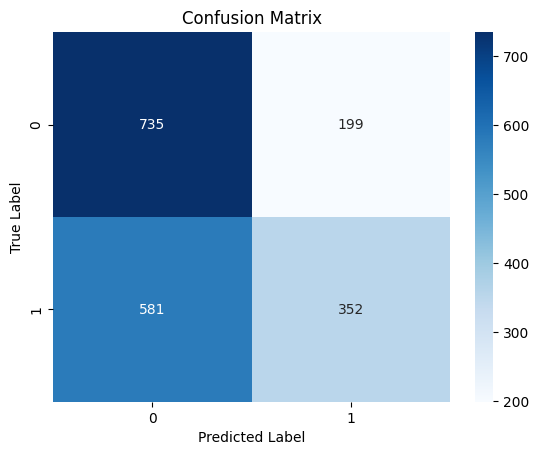

In [19]:
run_bert_training("bert-base-cased", "ger")